<a href="https://colab.research.google.com/github/solislemuslab/dna-nn-theory/blob/master/scripts/ChIP_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resourse usage

- CPU: 2.77 GB
- GPU: 2.66 GB

# Setup

In [ ]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 2.7MB/s 


In [ ]:
import gc
import os

from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

pd.options.display.max_colwidth = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/data/ChIP-seq/'
!ls '{DATA_PATH}'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
motif_discovery_test.fasta   motif_occupancy_test.fasta
motif_discovery_train.fasta  motif_occupancy_train.fasta


## Inspect the files included in the dataset

In [ ]:
import re

base_url = 'http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/{}'
!curl {base_url.format('files.txt')} -so files.txt

In [ ]:
with open('files.txt', 'r') as f:
    with open('output.txt', 'w') as out:
        for line in f:
            out.write(re.sub('control=.+?; ', '', line))

files = pd.read_csv('output.txt', header=None, index_col=0, sep=';?\\s+', engine='python')
files.drop(columns=[10, 11, 12], inplace=True)
files.index.name ='file'
files.columns = files.iloc[0].str.split('=', expand=True)[0]
files = files.apply(lambda ser: ser.str.split('=', expand=True)[1]
                    if ser.str.count('=').all() else ser)
files.reset_index(inplace=True)
files.to_csv('output.csv', index=False)
files['file'] = files['file'].str.replace('.narrowPeak.gz', '')
files.head()

,file,project,lab,composite,dataType,view,cell,treatment,antibody,dataVersion,dccAccession,controlId,quality,tableName,type,md5sum,size
0,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,Dnd41,None,CTCF,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,d24dcb...,966K
1,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,Dnd41,None,EZH2_(...,ENCODE,wgEnco...,wgEnco...,caution,wgEnco...,narrow...,effd48...,43K
2,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,GM12878,None,CTCF,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,fef0af...,982K
3,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,GM12878,None,EZH2_(...,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,9a8766...,66K
4,wgEnco...,wgEncode,Broad,wgEnco...,ChipSeq,Peaks,H1-hESC,None,CHD1_(...,ENCODE,wgEnco...,wgEnco...,good,wgEnco...,narrow...,71891a...,184K


# Download data

In [ ]:
from bs4 import BeautifulSoup
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import requests
from tqdm.notebook import tqdm

In [ ]:
tasks = {'motif_discovery', 'motif_occupancy'}

def mkdir(path):
    try:
        os.mkdir(path)
    except:
        pass

def zeng_2016(task):
    if task not in tasks:
        raise ValueError(f'task can only be in {tasks}, got \'{task}\'')
    r = requests.get(f'http://cnn.csail.mit.edu/{task}/')
    soup = BeautifulSoup(r.text)
    trs = soup.find('table').find_all('tr')[3:-1]
    folders = [tr.a.text for tr in trs]
    mkdir(task)

    for folder in tqdm(folders):
        mkdir(os.path.join(task, folder))
        for data in ['train.data', 'test.data']:
            r = requests.get(f'http://cnn.csail.mit.edu/{task}/{folder}/{data}')
            with open(os.path.join(task, folder, data), 'w') as f:
                f.write(r.text)

In [ ]:
# 5~9 minutes each depending on the network
zeng_2016('motif_discovery')
zeng_2016('motif_occupancy')

In [ ]:
df = pd.read_csv('motif_discovery/wgEncodeAwgTfbsBroadDnd41CtcfUniPk/train.data', sep=' ', header=None, nrows=5)
df

,0,1,2
0,>chr3:...,CTGGCT...,1
1,>chr1:...,TGAAGT...,1
2,>chr5:...,GACCTT...,0
3,>chr3:...,ACTCAC...,1
4,>chr13...,TCCGCT...,0


# Load and transform raw data

In [ ]:
def load_zeng_2016_as_df(path, file):
    '''load the downloaded files into a single DataFrame'''
    dfs = []
    for folder in tqdm(os.listdir(path)):
        try:
            df = pd.read_csv(os.path.join(path, folder, file), sep=' ', header=None)
            dfs.append(df)
        except:
            print(f'Skip {folder}')
            continue
    result = pd.concat(dfs)
    result.sort_index(inplace=True)
    return result

def df_to_fasta(df, file):
    '''dump the DataFrame as a .fasta file, skip sequenecs that have N'''
    gen = (
        SeqRecord(Seq(record[1]), id='', name='', description=str(record[2]))
        for idx, record in df.iterrows()
        if not 'N' in record[1]
    )
    with open(DATA_PATH + file, 'w') as f:
        SeqIO.write(tqdm(gen), f, 'fasta')

def summary(df):
    '''
    plot stats for the class distribution

    the top figure shows the number of files with certain number of sequences
    the bottom figure shows the class distribution if we take certain number of
    sequences from each file (a file doesn't contribute any more after all its
    sequences are taken)
    '''
    stats = df.groupby(by=df.index)[2].agg(['count', 'sum'])
    cumsum = stats.cumsum()
    ratio = cumsum['sum'] / cumsum['count']

    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
    stats['count'].plot(ax=ax0)
    ratio.plot(ax=ax1)

    ax0.set_xlabel('# sequences')
    ax0.set_ylabel('# files')
    ax1.set_xlabel('# sequences taken from each file')
    ax1.set_ylabel('% of positive samples')

    ax0.grid();ax1.grid()

## Motif discovery training set

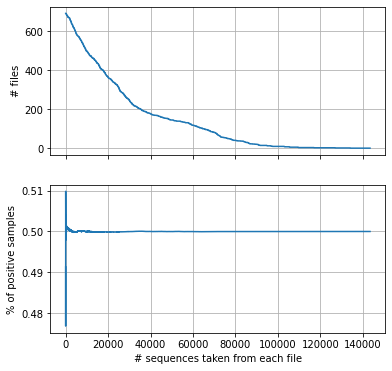

In [ ]:
motif_discovery_train = load_zeng_2016_as_df('motif_discovery', 'train.data')
summary(motif_discovery_train)

In [ ]:
# 20464149it [49:16, 6922.75it/s]
df_to_fasta(motif_discovery_train, 'motif_discovery_train.fasta')

In [ ]:
del motif_discovery_train
gc.collect()

4

## Motit occupancy training set

Skip wgEncodeAwgTfbsHaibEcc1GrV0416102Dex100nmUniPk



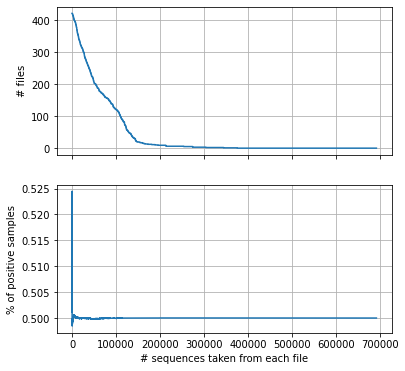

In [ ]:
# motif_occupancy/wgEncodeAwgTfbsHaibEcc1GrV0416102Dex100nmUniPk/train.data is corrupted
motif_occupancy_train = load_zeng_2016_as_df('motif_occupancy', 'train.data')
summary(motif_occupancy_train)

In [ ]:
# 28694274it [1:10:03, 6826.32it/s]
df_to_fasta(motif_occupancy_train, 'motif_occupancy_train.fasta')

In [ ]:
del motif_occupancy_train
gc.collect()

4969

## Test set

In [ ]:
# test data

# 5116385it [12:25, 6860.87it/s]
motif_discovery_test = load_zeng_2016_as_df('motif_discovery', 'test.data')
df_to_fasta(motif_discovery_test, 'motif_discovery_test.fasta')
del motif_discovery_test
gc.collect()

# 7178864it [17:34, 6826.32it/s]
motif_occupancy_test = load_zeng_2016_as_df('motif_occupancy', 'test.data')
df_to_fasta(motif_occupancy_test, 'motif_occupancy_test.fasta')
del motif_occupancy_test
gc.collect()

8

# Prepare tokenizer and data generator

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts('ATCG')

def data_generator_from_fasta(file):
    def generator():
        f = open(DATA_PATH + file, 'r')
        for record in SeqIO.parse(f, 'fasta'):
            try:
                x = np.array(tokenizer.texts_to_sequences(record)) - 1
            except:
                x = np.array(tokenizer.texts_to_sequences(record.seq._data.replace('N', 'A'))) - 1
                print('skip')
            x = np.expand_dims(keras.utils.to_categorical(x, 4), axis=-1)
            yield (x, record.name)
        f.close()
    return generator

# Motif Discovery

- 35 sequences have `N`

## Create dataset

In [ ]:
batch_size = 1024
dataset = tf.data.Dataset.from_generator(
    data_generator_from_fasta('motif_discovery_train.fasta'),
    output_types=(tf.float32, tf.float32),
    output_shapes=((101, 4, 1), ())
)
dataset = dataset.shuffle(10000).batch(batch_size).prefetch(2)
print('input shape: ', dataset.element_spec[0].shape)
print('output shape:', dataset.element_spec[1].shape)

input shape:  (None, 101, 4, 1)
output shape: (None,)


## Build model

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(128, (24, 1), padding='same', activation='relu', input_shape=(101, 4, 1)),
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 101, 4, 128)       3200      
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
______________________________________________________

In [ ]:
log = open('log_discovery.csv', mode='w')
writer = DictWriter(log, ['batch', 'loss', 'accuracy'])

log_callback = keras.callbacks.LambdaCallback(
    on_batch_end=lambda batch, logs: writer.writerow({'batch': batch, 'loss': logs['loss'], 'accuracy': logs['accuracy']}),
    on_train_end=lambda logs: log.close()
)

In [ ]:
# 33ms/step
# 319752steps
# 20464149 / 64 * 33 / 1000 / 3600 = 2.9 hours
history = model.fit(dataset, batch_size=batch_size, epochs=1, callbacks=[log_callback])

# Motif occupancy

## Create dataset

In [ ]:
batch_size = 1024
dataset = tf.data.Dataset.from_generator(
    data_generator_from_fasta('motif_occupancy_train.fasta'),
    output_types=(tf.float32, tf.float32),
    output_shapes=((101, 4, 1), ())
)
dataset = dataset.shuffle(10000).batch(batch_size).prefetch(2)
print('input shape: ', dataset.element_spec[0].shape)
print('output shape:', dataset.element_spec[1].shape)

input shape:  (None, 101, 4, 1)
output shape: (None,)


## Build model

In [ ]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(128, (24, 1), padding='same', activation='relu', input_shape=(101, 4, 1)),
    keras.layers.GlobalMaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adadelta', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 101, 4, 128)       3200      
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 7,394
Trainable params: 7,394
Non-trainable params: 0
______________________________________________________

In [ ]:
log = open('log_occupancy.csv', mode='w')
writer = DictWriter(log, ['batch', 'loss', 'accuracy'])

log_callback = keras.callbacks.LambdaCallback(
    on_batch_end=lambda batch, logs: writer.writerow({'batch': batch, 'loss': logs['loss'], 'accuracy': logs['accuracy']}),
    on_train_end=lambda logs: log.close()
)

In [ ]:
# 453ms/step
# 28021steps
# 28694274 / 1024 * 453 / 1000 / 3600 = 3.5 hours
history = model.fit(dataset, batch_size=batch_size, epochs=1, callbacks=[log_callback])

     21/Unknown - 10s 453ms/step - loss: 0.6969 - accuracy: 0.5005skip
     81/Unknown - 36s 449ms/step - loss: 0.6964 - accuracy: 0.5018skip
    203/Unknown - 91s 447ms/step - loss: 0.6960 - accuracy: 0.5015skip
    353/Unknown - 157s 446ms/step - loss: 0.6957 - accuracy: 0.5015skip
    565/Unknown - 251s 445ms/step - loss: 0.6952 - accuracy: 0.5012skip
    584/Unknown - 260s 445ms/step - loss: 0.6951 - accuracy: 0.5014skip
    763/Unknown - 340s 446ms/step - loss: 0.6947 - accuracy: 0.5016skip
    802/Unknown - 358s 446ms/step - loss: 0.6947 - accuracy: 0.5017skip
    809/Unknown - 361s 446ms/step - loss: 0.6947 - accuracy: 0.5017skip
    823/Unknown - 367s 446ms/step - loss: 0.6946 - accuracy: 0.5017skip
    908/Unknown - 406s 447ms/step - loss: 0.6946 - accuracy: 0.5012skip
    920/Unknown - 412s 447ms/step - loss: 0.6946 - accuracy: 0.5012skip
    945/Unknown - 423s 448ms/step - loss: 0.6946 - accuracy: 0.5011skip
    990/Unknown - 444s 448ms/step - loss: 0.6946 - accuracy: 0.5011